# Coursework 2 for Cardiac MR Image Segmentation (2020-2021)


# Introduction

We were tasked with generating a semantic segmentation of CMR images using deep learning, in particular multiple CNN architectures. The data we had consisted of the following:
- Training: 100 images & ground truths
- Validation: 20 images & ground truths
- Test: 80 images

The task was a supervised ML task, as we had both the input data and their correct label, and we were training the CNN to correctly classify each pixel into a region based on that data. One of the unique challenges of the data we had was the distribution of classes, in particular the fact that the “background region” class 0 was prevalent in every image. This could easily provide CNNs with the trap of “learning” to classify everything as 0 and it would provide good accuracy by default. Our aim was to find a good CNN architecture that provides an accurate classification of each pixel of the heart images into the 4 region classes in an efficient, stable and consistent manner.


## Our chosen architecture: U-Net

U-Net (Ronneberger, Fischer and Brox, 2015) is a fast and precise architecture. Its name is due to the U-like shape it has when visualised. The left part of the “U” if the contract path. This consists of the repeated application of two or more 3x3 convolutions, each followed by ReLU, batch normalisation and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step, we double the number of feature channels. The expansive path consists of an upsampling of the feature map followed by a 2x2 convolution that halves the number of feature channels, a concatenation with the corresponding cropped feature map from the contracting path, and two or more 3x3 convolutions, each followed by ReLU and batch normalisation.
This architecture is effective, firstly because downsampling allows the more general and less detailed features to be extracted. Additionally, in the expansive path, the concatenation with feature maps from the contract path means that the more detailed features are not lost after downsampling. As a result, U-Net is able to extract both more general and more specific features from an image. 
In our tests, this architecture was optimal in terms of training time and accuracy. For this reason, it was selected as our preferred architecture for the rest of the experiments.


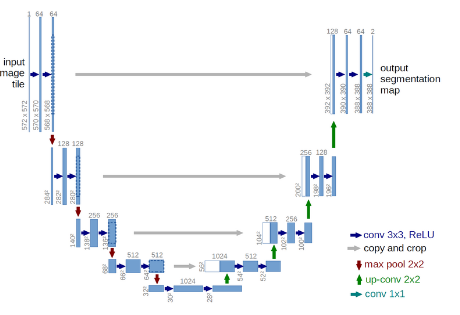
Diagram of the U-Net architecture. - (Ronneberger, Fischer and Brox, 2015)

## Other Architectures Attempted
### A different biological segmenter
One of the network architectures that we tested was the one described in the paper "Toward Automatic Phenotyping of Developing Embryos from Videos" (Feng Ning et al., 2005). This paper describes a neural network that was used for segmenting biological images of cells. This seemed like it might be an appropriate architecture to use as it was also specifically applied to a similar problem with grayscale biological images. The network was fairly straightforward to implement with PyTorch, and after being trained for 1000 epochs it was getting near-zero loss (as measured by the cross entropy for each output label) on the training set. However, the two problems were subpar generalisation to the test set (never doing better than an average Dice score of about 0.73) and outputting masks of lower resolution than the input image. The network has two subsampling layers that both reduce the horizontal and vertical resolution by 50%, so the final mask is 1/4 the size of the image in both directions. The lack of pixel-level accuracy is probably a reason why the Dice scores were poor, while the cross-entropy (which was only calculated once for each output pixel by requiring it to have the most common label among the 16 corresponding input pixels) was quite good. We can conclude that this is probably a good network structure, but only for an application that does not require pixel-level accuracy.
### AlexNet
Krizhevsky, Sutskever and Hinton (2017) introduce AlexNet for classification of images; while the main purpose of the architecture is for classification, we believed the success for classification would translate to semantic segmentation. With a rough implementation, the model initially produced static masks. However, by changing the optimiser from the original stochastic gradient descent to Adam we saw that the model would learn at a steady rate. After 100 epochs it would produce the mask with high accuracy on the training data. We tested the model on a validation dataset which the model has not seen before using the dice score as a metric of accuracy. Unfortunately, the dice score average was 0.45 this signifies the model has heavily overfitted the training data. An attempt to solve this issue was to change the number of epochs and increase the dropout rate. However, this seems to not have solved the problem so we will not be pursuing this model.
### SegNet
We’ve looked at SegNet (Badrinarayanan, Kendall and Cipolla, 2015) as another option. SegNet uses an encoder-decoder architecture, based on that of VGG16, using the same topology for the 13 convolutional layers (Simonyan and Zisserman, 2015). What differentiates SegNet from other architectures is that it is maintaining the indices from the max-pooling layers, and using them in the unpooling layers where maximal values are placed according to their max-pooling index and non-maximal values are set to 0. It was mostly developed for scene understanding applications. We trained it using Adam for 200 epochs and it achieved a pretty good Dice score of about 0.82 on training data and 0.80 on both validation data and Kaggle, meaning it wasn’t heavily overfitted to the training data. However, we found that SegNet is meant to use all of the pre-trained convolutional layer weights from VGG net as pre-trained weights (Badrinarayanan, Kendall and Cipolla, 2015). Since U-Net was proposed specifically for the medical community, it has fewer layers to manage (no conv5 block by default), doesn’t require pre-trained weights from VGG16 (Ronneberger, Fischer and Brox, 2015), as well as providing better overall results for our tests, we decided against choosing SegNet as our final architecture. 



# Implementation

## 1. Load, show, and save images with OpenCV
The code below was provided

In [ ]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

In [ ]:
import os
import cv2 #import OpenCV

data_dir = './data/test'
image = cv2.imread(os.path.join(data_dir,'image','cmr170.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr170_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
#cv2.imwrite(os.path.join('./','cmr121.png'), mask*85)

## 2 Define a segmentation model with Pytorch


### 2.1 Define a DataLoader

Dataloaders were provided.



In [ ]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


### 2.2 Define a Segmentation Model

Below is our CNN model for semantic segmentation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
'''This model has been created by building upon the code found at:
https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705
(Cordeiro, 2020)
'''
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # defining the layers of the U-Net
        
        # contract segment
        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)
        self.conv4 = self.contract_block(128, 256, 3, 1)
        self.conv5 = self.contract_block(256, 512, 3, 1)
        
        # expand segment
        self.upconv5 = self.expand_block(512, 256, 3, 1)
        self.upconv4 = self.expand_block(256*2, 128, 3, 1)
        self.upconv3 = self.expand_block(128*2, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)
        
        # upsampling part
        upconv5 = self.upconv5(conv5)
        upconv4 = self.upconv4(torch.cat([upconv5, conv4], 1))
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
        
        return F.softmax(upconv1, dim = 1)
    
    # A contract block is a sequential application of convolution, ReLU, and batch normalisation, and finally maxpooling
    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    # An expand block is a sequential application of convolution, ReLU, and batch normalisation
    # A transposed 2D convolution is then applied to upsample the feature map by a factor of 2.
    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

### 2.3 Define a Loss function and optimizer


In [ ]:
from torch.autograd import Variable

def split_masks(masks, num_classes):
    '''This function takes a mask in the format of a 2d tensor of size (h,w) with values 0 -> num_classes. 
    It then oututs an 3d tensor of size (num_classes,h,w), which contains a 2d array for each classes from 0 -> num_classes.
    Each element contains a 1 if it is that classes and a 0 if it is not that class.
    
    For example:
    
    [[1,2,1]              [[[0,0,0]  [[1,0,1]  [[0,1,0]
     [0,1,1]       =>       [1,0,0]   [0,1,1]   [0,0,0]  
     [0,2,0]]               [1,0,1]]  [0,0,0]]  [0,1,0]]]                                                       '''
    
    height,width = masks.shape[1], masks.shape[2]
    batch_size = masks.shape[0]
    
    indices = torch.arange(0, num_classes).repeat_interleave(height * width).view((num_classes, height, width))
    indices = torch.cat(2 * [indices])
    
    masks_repeated = masks.repeat_interleave(num_classes, dim = 0)

    split_masks = (masks_repeated == indices).type(torch.DoubleTensor).view((batch_size, num_classes, height, width))
    
    return split_masks 

def cross_entropy_loss(y, predict, avoid_zero_const = 0.001):
    '''This is a custom loss function for cross entropy loss. 
    It takes 2 probability distributions (y and predict) and outputs the average cross entropy between them.
    
    avoid_zero_const is for avoiding calling log(0), which would cause an error.
    
    The custom loss function is used because when programming this we were unaware of the in built cross entropy 
    loss function. However, by implementing it ourselves we were able to understand cross_entropy_loss in 
    more detail, which gave us a better appreciation for what it is doing and why it works well.
    
    To calculate entropy we used this formula:
    
    
    cross_entropy_loss = -(ylog(p) + (1-y)log(1-p))
    
    Cross entropy is effective, because not only does it penalise incorrect classifications, but it also 
    penalises uncertainty. For example, if one model had 0.6 certainty of the correct classification, but 
    a second one had 0.9 certainty, the second one would achieve a better cross_entropy score and hence a 
    lower cross_entropy_loss (due to the negation).
    '''
    
    y = y.flatten()
    predict= predict.flatten() 
    log_predict = torch.log(predict + avoid_zero_const)
    
    log_1_minus_predict = torch.log(1 - (predict - avoid_zero_const))
    
    cross_entropies = (y * log_predict) + ( (1 - y) * log_1_minus_predict ) 
    
    return -1 * (1/cross_entropies.shape[0]) * (cross_entropies.sum())

    
import torch.optim as optim
model = UNET(1,4)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

### 2.4 Training


In [ ]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are consideredvolumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

def load_model(path, blank_model):
    '''Loads the weights into a blank model from a .pt file.
    The architecture of the blank model and the .pt file must match.'''
    blank_model.load_state_dict(torch.load(path))
    blank_model.eval()
    return blank_model


def evaluate_model(model_path, blank_model, show = True): 
    '''Gets the average dice score for the model on the validation set.
    If show = True it will display all the masks generated with their
    dice scores'''
    
    if model_path != "":
        eval_model = load_model(model_path, blank_model)
    else:
        eval_model = blank_model
    
    data_path = './data/val'
    num_workers = 4
    batch_size = 1

    val_set = TrainDataset(data_path)
    val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers,batch_size=batch_size, shuffle=True)

    n = 0
    total_dice = 0

    for iteration, sample in enumerate(val_data_loader):
        img, mask = sample

        img = img.view(batch_size, 1, img.shape[1], img.shape[2])

        out = eval_model(img)
        out = out.argmax(dim = 1)

        for i in range(batch_size):
            dice_score = 0
            for l in range(1, 4):
                dice_score += categorical_dice(mask[0].numpy(), out[0].numpy(), label_class = l)
            dice_score = dice_score/3
            if(show):
                show_image_mask(mask[0,...].squeeze(), out[0,...].squeeze()) 
                print(dice_score)
            
            total_dice += dice_score
            n += 1

        plt.pause(1)
    
    return total_dice / n
    
    

In [ ]:
from torch.utils.data import DataLoader
import numpy as np

data_path = './data/train'
num_workers = 4
batch_size = 2
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

epoch = 140

losses = []
dice_scores = []
model.train()
for e in range(epoch):
    # Fetch images and labels.  
    for iteration, sample in enumerate(training_data_loader):
        img, mask = sample
        model.zero_grad()
        img = img.view(img.shape[0], 1, img.shape[1], img.shape[2])
        out = model(img)
        loss = cross_entropy_loss(split_masks(mask, 4), out)
        loss.backward()
        optimizer.step()    
        
    out_mask = out.argmax(dim = 1)
    
    print("Epoch: {0}   Loss: {1}".format(e, loss.item()))
    
    # Evaluate every 10 epochs
    if(e % 10 == 0):
        model.eval()
        dice = evaluate_model("", model, show = False)
        losses.append(loss.item())
        dice_scores.append(dice)
        print("Dice: {0}".format(dice))
        model.train()
    
    
    


In [ ]:
#SAVES THE MODEL TO A FILE
PATH = "UNET.pt"
torch.save(model.state_dict(), PATH)


#PLOT THE LOSS AND DICE SCORE
import matplotlib.pyplot as plt

x = np.arange(0,epoch,10)


plt.plot(x, dice_scores, label = "Dice Score")
plt.plot(x, losses, label = "Loss")

plt.title('Dice Score and Loss Against Epochs')
plt.xlabel('Epochs')
plt.legend()
plt.show()







### 2.5 Testing


In [ ]:
import numpy as np
from torch.autograd import Variable

In [ ]:
# Load saved model and deploy it to all data in test set to produce segmentation masks in png images 
# valued 0,1,2,3, which will be used for the submission to Kaggle

def load_model(path, blank_model):
    blank_model.load_state_dict(torch.load(path))
    blank_model.eval()
    return blank_model

data_path = './data/test'
num_workers = 4
batch_size = 1

model = load_model(PATH, UNET(1,4))

test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

# works on windows. on linux the images may not be taken in order
img_num = 121
for iteration, sample in enumerate(test_data_loader):
    img_name = "./data/test/mask/cmr{0}_mask.png".format(img_num)
    img_num += 1
    img = sample
    img = img.view(1, 1, img.shape[1], img.shape[2])
    out = model(img)
    out = out.argmax(dim = 1)[0]

    cv2.imwrite(img_name, out.numpy())

## 3 Evaluation


### 3.1 Dice Score

Dice method defined above.

In [ ]:
evaluate_model(PATH, UNET(1,4))

### 3.2 Submission


In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()
    
    
submission_converter("./data/test/mask","")

# Experiments
## Learning Rate
We did an experiment with adjusting the learning rate to see if that had an impact on the final performance. The performance was measured by calculating the average Dice score on the validation set after a given number of epochs. The first experiment used a wide variety of possible learning rates ranging from 0.001 to 1 in order to detect viable ranges for the learning rate to inform future experiments. As this was testing a large number of different learning rates and was not intended to be the final experiment, each run was only trained for 200 epochs to save time.


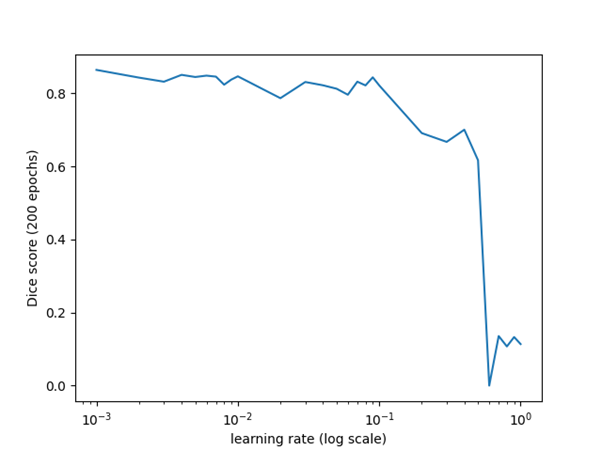

As you can see from the above graph (which uses a log scale on the x-axis), it was clear that there was very little value in going above about 0.01. The 0 from 0.6 was probably an error, but as all the values in that region were terrible anyway then it didn't seem worth rerunning the experiment.

The second experiment focused only on very small values compared to the previous test.  As the difference between the low values seemed within random variation, and as higher epoch numbers normally benefit low learning rates more than high learning rates, we only focused on learning rates below 0.025 for this test. The advantages of being able to run multiple tests per value and run tests for 300 epochs rather than just 200 seemed like enough of a benefit to offset the disadvantage of a narrower range of tested values.


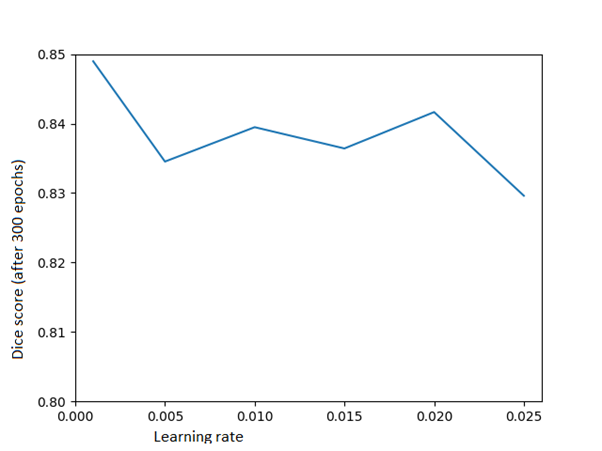

As you can see from the above graph, the difference was still fairly minimal, although as each value was tested seven times to get the above values (rather than just one or two as in the previous graph), it may be the case that the small differences are actually reflective of a real performance difference. As 0.001 was still the best performing learning rate, the next step was to investigate values smaller than that. We hadn't done that with the previous experiments because 0.001 seemed like so tiny a value (in comparison to the learning rates that had worked well for the previous "fashion categorisation" network) that the best value must be higher. As the results proved this wrong, an exploration of smaller values made sense.



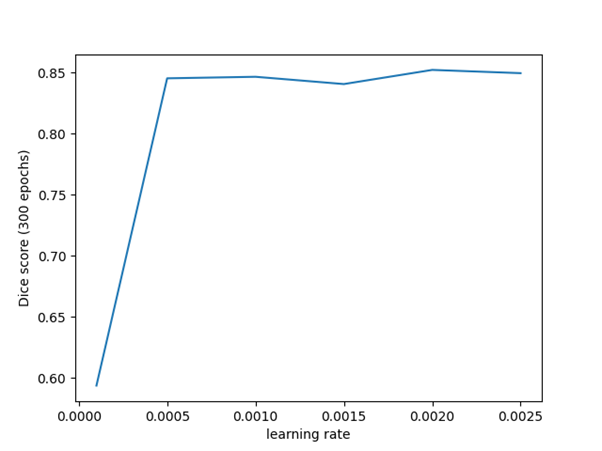

The difference is again fairly minimal aside from the extremely low value (0.0001), which performs poorly due to presumably not being trained for enough epochs for the values to change enough. We can therefore conclude that any value of around 0.001 is appropriate for the learning rate.


## Batch size
We looked at multiple batch sizes that would work with the amount of training data we had: 2, 4, 8, 16 and 32. Whilst training for 250 epochs, we looked at the loss on the training set and the Dice score on the validation set every 5 epochs and put them in a plot. As for other hyperparameters, we kept the learning rate 0.001, we used Adam and ReLU. For the batch sizes that are not divisors of 100, the last batch was automatically created of smaller size. For this experiment, we discarded that smaller last batch for 2 reasons: 1. The data is shuffled so images discarded in one epoch will be used in another one eventually; 2. We wanted to keep the experiment “pure” by only using batches of the specified size. Here are the results:


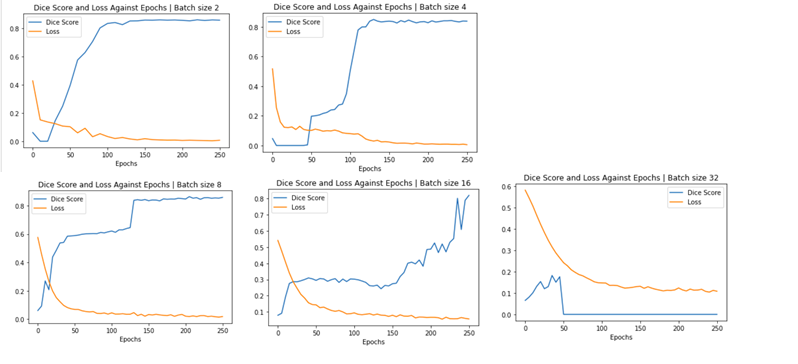

From our experiments, we concluded that the bigger the batch size, the later the Dice score will reach its peak value. With a big batch size, we also saw that the Dice score wasn’t increasing steadily, but rather in unpredictable bursts. While the Dice was behaving rather poorly with bigger batch sizes, the loss was behaving quite predictably, always reducing in an exponential curve. However, the minimum value of the loss was getting bigger with the batch size, meaning the smaller batch size also provided the smallest value for the loss.


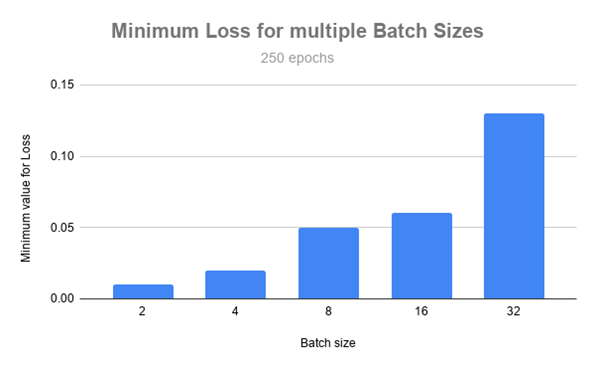

We think the bigger batch sizes are performing worse because of the amount of data we have. Using batch size 32 means there are only 3 full batches per epoch and that might not be enough for training to be effective.
Following these experiments, we moved forward with a batch size of 2 for our architecture.



## Activation Functions
The activation functions we experimented on were Sigmoid, LeakyReLU, ReLU, Tanh and HardTanh. We trained the model on the different activation functions while keeping the rest of the hyperparameters constant. With the trained model we produced a metric of accuracy by inputting the validation data through the model and calculating the average dice score.


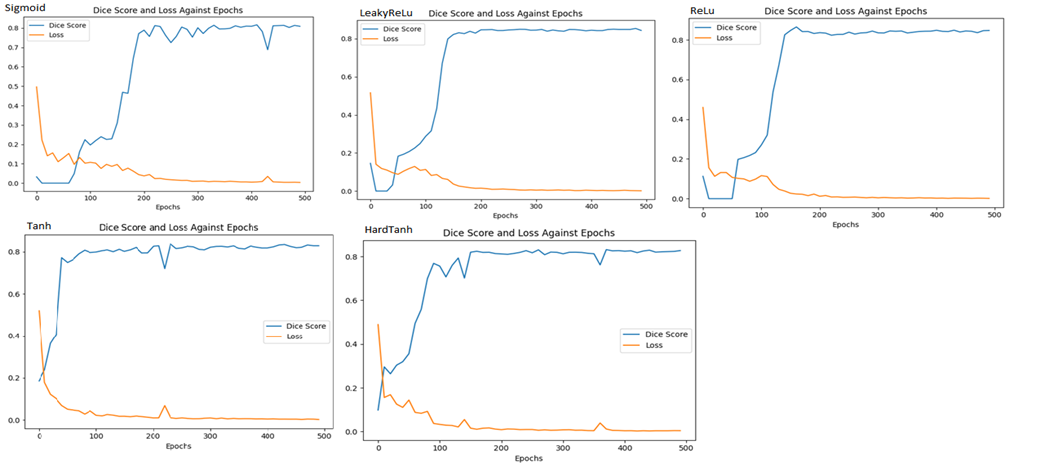

The results above show the loss and dice score against epoch for the different activation functions on the training data. All activation functions end up with approximately 0.8 dice score. Nothing is separating them, apart from the rate they can reach their maximum dice score or minimum loss. TanH and HardTanH produces a higher initial dice score compared to the others and learns initially very fast while the other functions start with very low dice scores. The dice scores can be as low as 0 and stay low until approximately 70 epochs before we see an increase in dice score. Comparing all the functions ReLu and leaky ReLu seems to be the most stable when reaching their maximum dice score, with the graph showing less oscillation at max dice score.

Below you can see the results of each activation function. We can see that ReLU and Leaky ReLU have the highest average dice scores of 0.844 and 0.847 respectively. HardTanh seems to have overfitted the training data as the graph shows a dice score of above 0.8 and on the validation, we see the dice score of 0.78. We can eliminate HardTanh as the activation function we will use for our final model. The evidence shows Leaky ReLu’s dice score is 0.003 better than ReLU’s dice score, however, we believe this to be noise and through reinforcement of the other researched architecture, ReLu seems to be the most optimal activation function. The difference is small enough that a different validation set may cause ReLU to have a better score. We can also see from the previous graphs that ReLu is stable. Therefore ReLu will be used as our final activation function for our model.




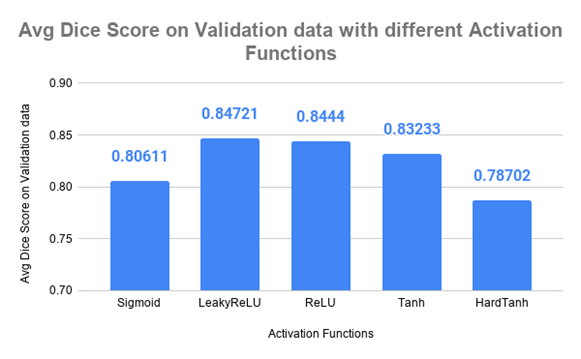

### Number of in-channels and out-channels
We have also run a few tests on the number of in-channels and out-channels of the convolutional layers in the contract and expand blocks. We wanted to see if the particular size of our training images could benefit from smaller or larger values for these channels. We trained the network with LR 0.001, using Adam, ReLU and Batch size 2 for 250 epochs, recording the dice score on the validation set every 10 epochs, for multiple configurations. Here are the results:

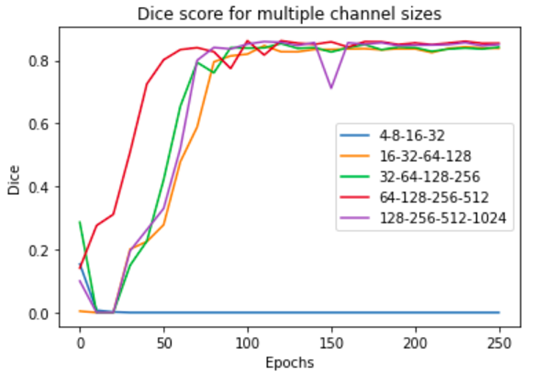

From the graph, it is evident that small values for the channels fail in making the network learn anything. The bigger values all end up making the network learn in about the same time and achieve similar dice scores. However, the one configuration that stood out as learning the fastest and also achieving the best maximum dice score (albeit by a small margin of 0.02) was 64-128-256-512. We used these values in the final network.


## Network Topology
For network topology, we looked at two variables: The number of blocks in the model, and the number of “block depth” or 2D convolution layers per block:


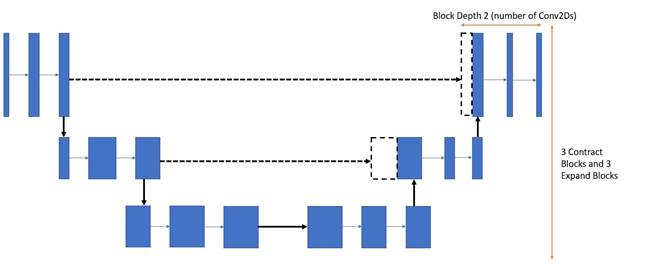

To begin with we recorded the classification average accuracy of different topologies on the validation data set. We tried block depths of 2-4 and numbers of blocks from 2-5, and each experiment was run for 250 epochs on the provided training data with a batch size of 2 and a learning rate of 0.001. Below are the results:

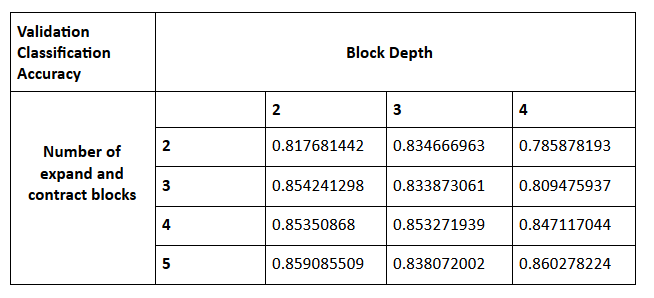

The main conclusion that can be drawn from these results is that the classification accuracy improves with the number of contract and expand blocks. It is not possible to have more than 5 blocks without changing the factor with which the blocks are downsampled (in this case 2), so a future experiment might be to change this factor and add more blocks to see if the accuracy can be improved. For now, though we will conclude that 5 is the optimal number of blocks.
The results do not show any obvious correlation between classification accuracy and block depth. To test this we ran some further experiments on some higher blocks depths, to see if a trend could be discovered:


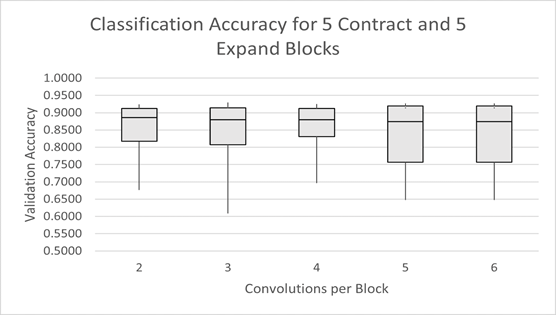

The results obtained indicated that there was no strong relationship between the block depth and validation accuracy; any difference in the box plots is most likely dependent on the initial weights and not the number of conv2d layers per block. Therefore it is better to use a lower depth in order to reduce training time, such as 2.
In conclusion, to optimise training time and performance we should use a block depth of 2 and have 5 contract blocks and 5 expand blocks.



### Kernel size
We tested the effects of kernel size on the performance of U-Net. We tested all of the models using padding, with padding equal to (kernel size-1) \/2.  Removing the use of the kernel (moving to a 1\*1 kernel) made the model need more epochs to reach its final performance. Increasing the size of the kernel does not have a very noticeable effect on the performance of the model and increases the training time further. Because of this, we decided to keep the 3\*3 kernel


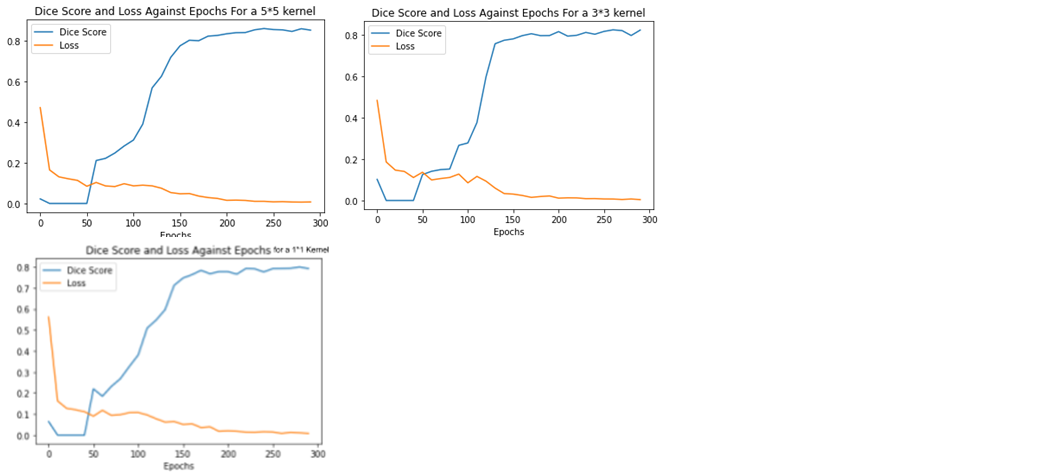

### Optimisers
The optimiser aims to minimise the cost function by finding the optimised value for weights. We tested Stochastic Gradient Descent (SGD), Adaptive Moment Estimation (Adam) which combines Adagrad and RMSprop, and AdamW which implements Adam except the weight decay is performed only after controlling the step size, which can improve efficiency.  We tested the dice score and loss for these three optimisers, over 200 epochs to save time.


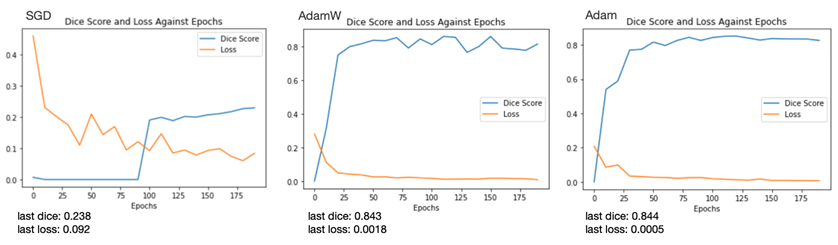

We observed that SGD was clearly sub-optimal, however, AdamW and Adam gave closer results. The loss for AdamW was superior to that of Adam, so we chose to use Adam as our preferred optimiser.



## Regularisation experiments
### Dropout
Generalisation performance of a neural network can sometimes be improved by randomly removing some neurons during the processing of each training example. We ran a test of this, measuring performance on the validation set after 300 epochs for different dropout rates (dropping neurons in the convolutional layers) up to 0.5.


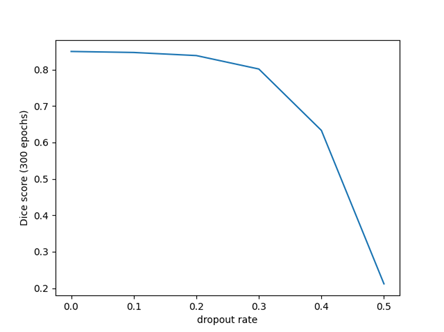

As the graph shows, there was no improvement in performance and performance does in fact get significantly worse with dropout rates above 0.2. As dropout layers seem expensive for PyTorch to run (as the network was taking much longer to run with them than it had been previously), possibly due to the need to generate lots of pseudorandom numbers, we decided not to investigate this any further. The final network does not use dropout.

### Augmented dataset
We also looked at how the dice score behaves when trained on the dataset augmented with mirrored versions of the images. We trained the network with the same hyperparameters with both the normal and augmented training sets and plotted the dice score on the validation set. Here are the results:


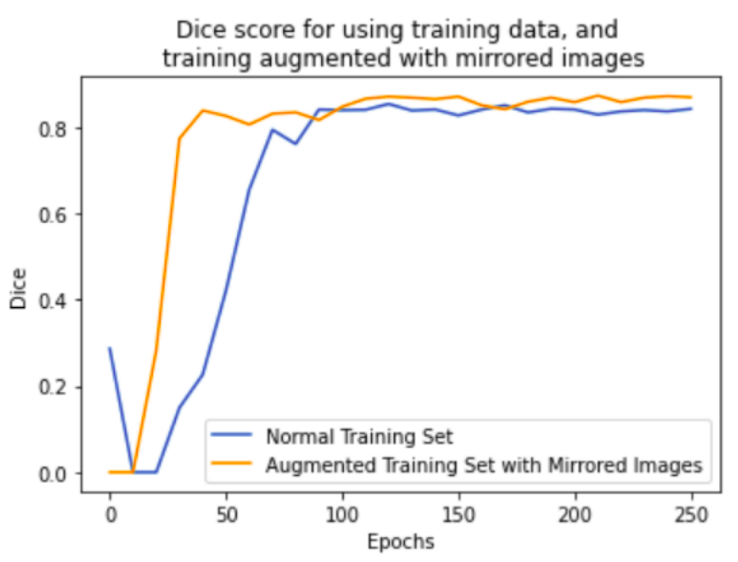

We observed that there was no significant increase in accuracy after 150 epochs. We chose to pick our preferred number of epochs using the early stopping method, to minimise overfitting, where a gap appears between the accuracy of the model on the training data and the testing data. The gap starts to form after 136 epochs, and accounting for some noise we chose 140 epochs as our final number of epochs.

### Early stopping
We were first concerned that, with the added mirrored data, the duration of an epoch would increase. After testing, we concluded there was virtually no difference. 
When choosing how many epochs to train the model for, the tradeoff is between an increased accuracy and added computation cost.



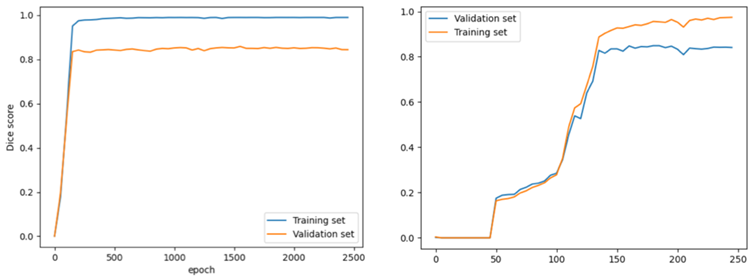

We observed that there was no significant increase in accuracy after 150 epochs. We chose to pick our preferred number of epochs using the early stopping method, to minimise overfitting, where a gap appears between the accuracy of the model on the training data and the testing data. The gap starts to form after 136 epochs, and accounting for some noise we chose 140 epochs as our final number of epochs.


# Conclusion: Final architecture, performance and statistical analysis

Final hyperparameters for our architecture:

- Learning rate: 0.001

- Batch size: 2

- Kernel size: 3

- Channel sizes: 32-64-128-256-512

- Epochs: 140

- Blocks: 5 blocks in each stage (contract, expand)

- Block depth: 2

- Activation function: ReLU

- Optimiser: Adam

### Best generalisation performance

Best Dice score on validation data: 0.86027

Best Kaggle score: 0.87568

### Individual class statistics

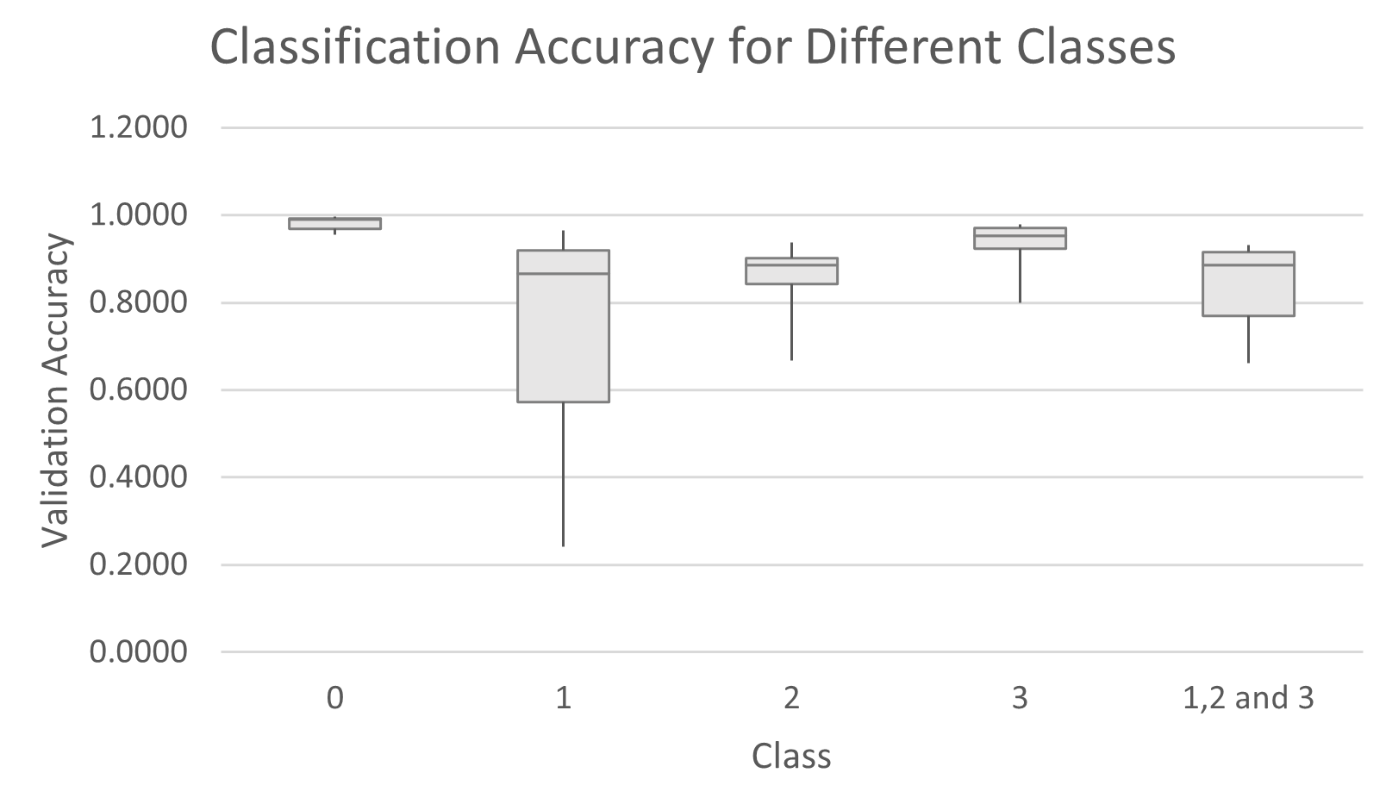
This graph shows that classes 0, 2 and 3 were being reliably classified, but our architecture seems to struggle with correctly classifying class 1. This might be because that segment occupies different locations in the images, compared to the white region which is almost always right in the centre. It is also similar in colour to the background so it may be hard for the classifier to discern between the two.

### Standard deviations per class
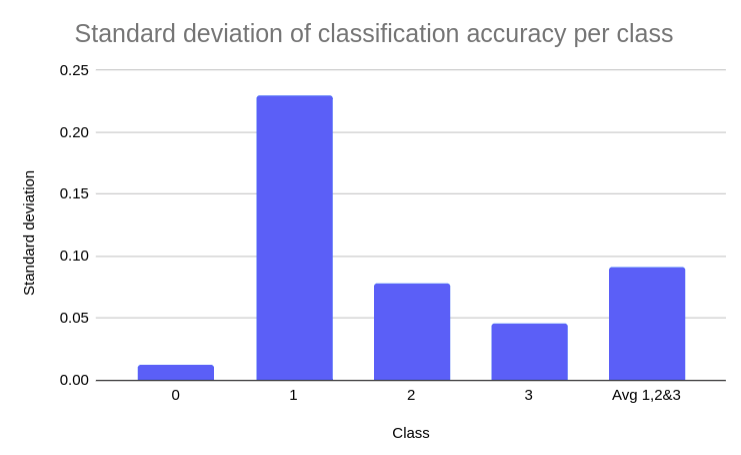

This again confirms that the most accurately classified class is 3 (white region) with the least amount of variation, and the most deviation occurred in class 1.

# References
Badrinarayanan, V., Kendall, A. and Cipolla, R. (2015). SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation. [online] Available at: https://arxiv.org/pdf/1511.00561.pdf [Accessed 8 Dec. 2020].

Feng Ning, Delhomme, D., LeCun, Y., Piano, F., Bottou, L. and Barbano, P.E. (2005). Toward automatic phenotyping of developing embryos from videos. IEEE Transactions on Image Processing, 14(9), pp.1360–1371.

Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2017). Imagenet classification with deep convolutional neural networks. Communications of the ACM, 60(6), 84-90.

Ronneberger, O, Fischer, P and Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. Medical Image Computing and Computer-Assisted Intervention (MICCAI), [online] Available at: https://arxiv.org/pdf/1505.04597.pdf [Accessed 15 Dec. 2020]

Simonyan, K. and Zisserman, A. (2015). VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION. [online] Available at: https://arxiv.org/pdf/1409.1556.pdf [Accessed 8 Dec. 2020].

Cordeiro, M. (2020). Creating a Very Simple U-Net Model with PyTorch for Semantic Segmentation of Satellite Images. [online] Available at: https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705 [Accessed 18 Dec. 2020]
